## Mixture Density Networks (Gaussian Mixture) for inverted sinusoidal function

### 0. Global seeding

In [1]:
from lagom.utils import set_global_seeds

set_global_seeds(seed=0)

### 1. Data generation

In [2]:
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader


class Data(Dataset):
    r"""Generate a set of data point of an inverted sinusoidal function. 
    i.e. y(x) = 7sin(0.75x) + 0.5x + eps, eps~N(0, 1)
    
    Then we ask the neural networks to predict x given y, in __getitem__(). 
    In this case, the classic NN suffers due to only one output given input. 
    To address it, one can use Mixture Density Networks. 
    """
    def __init__(self, n):
        self.n = n
        self.x, self.y = self._generate_data(self.n)
    
    def _generate_data(self, n):
        eps = np.random.randn(n)
        x = np.random.uniform(low=-10.5, high=10.5, size=n)
        y = 7*np.sin(0.75*x) + 0.5*x + eps
        
        return np.float32(x), np.float32(y)  # Enforce the dtype to be float32, i.e. FloatTensor in PyTorch
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        # Retrieve the x, y value
        x = self.x[index]
        y = self.y[index]
        # Keep array shape due to scalar value
        x = np.array([x], dtype=np.float32)
        y = np.array([y], dtype=np.float32)

        return y, x

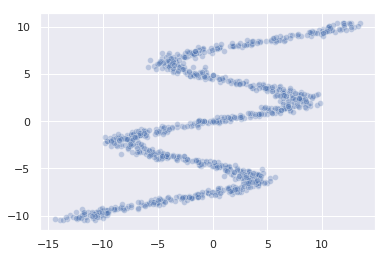

In [4]:
import seaborn as sns
sns.set()

data = Data(n=1000)
sns.scatterplot(data.y, data.x, alpha=0.3)

### 2. Make MDN network

In [5]:
import torch.optim as optim

from network import MDN

config = {'num_density': 20}
device = torch.device('cuda')

model = MDN(config, device)
optimizer = optim.Adam(model.parameters(), lr=5e-3)

### 2. Training

In [6]:
D = Data(n=2500)
train_loader = DataLoader(D, batch_size=64)

for i in range(1000):
    model.train()
    
    losses = []
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logit_pi, mean, std = model(data)
        loss = model.mdn_loss(logit_pi, mean, std, target)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    if i == 0 or (i+1)%100 == 0:
        #IPython.display.clear_output(wait=True)
        print(f'Epoch: {i+1}\t Loss: {np.mean(losses)}')

Epoch: 1	 Loss: 8.253870815038681
Epoch: 100	 Loss: 1.521627676486969
Epoch: 200	 Loss: 1.4734072268009186
Epoch: 300	 Loss: 1.4524978518486023
Epoch: 400	 Loss: 1.4401903927326203
Epoch: 500	 Loss: 1.4329430729150772
Epoch: 600	 Loss: 1.429561185836792
Epoch: 700	 Loss: 1.427915993332863
Epoch: 800	 Loss: 1.4244082942605019
Epoch: 900	 Loss: 1.4252410799264907
Epoch: 1000	 Loss: 1.421202141046524


### 3. Evaluation

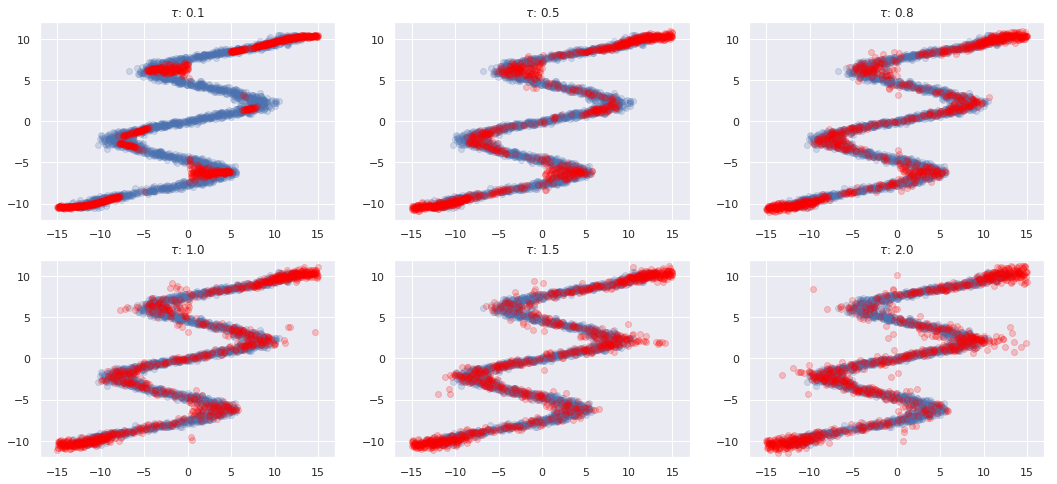

In [7]:
import matplotlib.pyplot as plt
sns.set()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6*3, 4*2))

# Temperature: controls the uncertainty. 
# Larger temperature leads to larger uncertainty. 
list_tau = [0.1, 0.5, 0.8, 1.0, 1.5, 2.0]

test_data = torch.tensor(np.linspace(-15, 15, num=1000, dtype=np.float32)).to(device).unsqueeze(1)

with torch.no_grad():
    model.eval()
    
    logit_pi, mean, std = model(test_data.to(device))
    
    for tau, ax in zip(list_tau, axes.reshape(-1)):
        samples = model.sample(logit_pi, mean, std, tau)
        samples.detach().cpu().numpy()

        ax.scatter(D.y, D.x, alpha=0.2)
        ax.scatter(test_data.detach().cpu().numpy(), samples.detach().cpu().numpy(), alpha=0.2, color='red')

        offset = 2
        ax.set_xlim(-15 - offset, 15 + offset)
        ax.set_ylim(-10 - offset, 10 + offset)
        
        ax.set_title(r'$\tau$: ' + str(tau))
    
#fig.savefig('samples.png')
#fig